#### This is a test project to investigate the training of ML classification model for fake news detection. The following websites will be useful sources:

    1. https://jovian.ai/piero-paialunga/notebook2/v/2&cellId=19-20
    2. https://towardsdatascience.com/fake-news-detection-with-machine-learning-using-python-3347d9899ad1

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast
from sklearn.decomposition import PCA
import tensorflow_hub as hub
from pycaret.classification import * 
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import plot_confusion_matrix
#from googletrans import Translator
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'sans-serif' 
plt.rcParams['font.serif'] = 'Ubuntu' 
plt.rcParams['font.monospace'] = 'Ubuntu Mono' 
plt.rcParams['font.size'] = 14 
plt.rcParams['axes.labelsize'] = 12 
plt.rcParams['axes.labelweight'] = 'bold' 
plt.rcParams['axes.titlesize'] = 12 
plt.rcParams['xtick.labelsize'] = 12 
plt.rcParams['ytick.labelsize'] = 12 
plt.rcParams['legend.fontsize'] = 12 
plt.rcParams['figure.titlesize'] = 12 
plt.rcParams['image.cmap'] = 'jet' 
plt.rcParams['image.interpolation'] = 'none' 
plt.rcParams['figure.figsize'] = (10, 10
                                 ) 
plt.rcParams['axes.grid']=False
plt.rcParams['lines.linewidth'] = 2 
plt.rcParams['lines.markersize'] = 8
colors = ['xkcd:pale range', 'xkcd:sea blue', 'xkcd:pale red', 'xkcd:sage green', 'xkcd:terra cotta', 'xkcd:dull purple', 'xkcd:teal', 'xkcd: goldenrod', 'xkcd:cadet blue',
'xkcd:scarlet']
bbox_props = dict(boxstyle="round,pad=0.3", fc=colors[0], alpha=.5)
import pandas as pd
import pycaret 


In [2]:
true_data = pd.read_csv('FakeNewsData/True.csv') #import the true data

In [3]:
fake_data = pd.read_csv('FakeNewsData/Fake.csv') #import the fake data

### Investigate the columns

In [4]:
true_data.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [5]:
fake_data.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


### A Target column is added and the data are merged and randomly mixed into a single DateFrame known as Data

In [6]:
true_data['Target']=['True']*len(true_data)
fake_data['Target']=['Fake']*len(fake_data)
data = true_data.append(fake_data).sample(frac=1).reset_index().drop(columns=['index']) # This target column is made up of strings

### Inspect the proportion of true to fake data we just mixed in

([<matplotlib.patches.Wedge at 0x1aac9922820>,
 [Text(-1.1412678264979264, 0.3708203718792959, 'Fake'),
  Text(1.1412678612166298, -0.3708202650260895, 'True')],
 [Text(-0.6657395654571236, 0.21631188359625594, '40.0%'),
  Text(0.6657395857097007, -0.21631182126521886, '60.0%')])

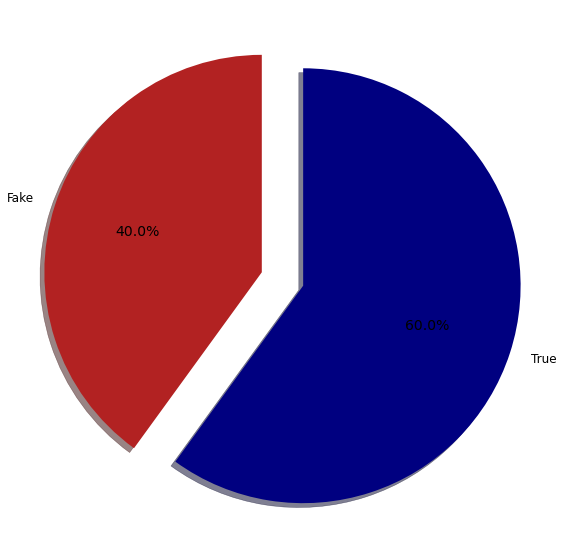

In [7]:

plt.pie(x=[10, 15],explode=[0.1,0.1],colors=['firebrick','navy'],startangle=90,shadow=True,labels=['Fake','True'],autopct='%1.1f%%')

### Update the DataFrame so that we are not working with categorical variables

In [8]:
data['label'] = pd.get_dummies(data.Target)['Fake']
data.head()

,title,text,subject,date,Target,label
0,PULL BACK THE CURTAIN ON NPR AND PBS SALARIES!...,Former Senator Jim DeMint speaks up in the WSJ...,left-news,"Mar 18, 2017",Fake,1
1,Trump pleads with Republicans to roll back Oba...,WASHINGTON (Reuters) - President Donald Trump ...,politicsNews,"July 24, 2017",True,0
2,Storm-battered Antigua asks U.S. to settle 12-...,GENEVA (Reuters) - Antigua and Barbuda asked t...,worldnews,"September 29, 2017",True,0
3,"Erdogan, Putin to discuss Syria, Jerusalem dur...",ANKARA (Reuters) - Russian President Vladimir ...,worldnews,"December 8, 2017",True,0
4,NATO's Stoltenberg says North Korea's 'reckles...,LONDON (Reuters) - North Korea s reckless beh...,worldnews,"September 10, 2017",True,0


### The goal: take the title of an article and predict wether or not the new is fake
We'll use BERT fine-tuning. The idea is simple. We have an extraordinary good model that is trained to perform good in terms of classification. We use this extraordinary good model (named BERT) and we fine tune it to perofmr our specific task. 

### Train-Validation split

In [9]:
train_text, temp_text, train_labels, temp_labels = train_test_split(data['title'], data['label'], 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=data['Target'])

### Validation-Test Split

In [10]:

val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

### Define the model and tokenizer of BERT
Tokenization basically refers to splitting up a larger body of text into smaller lines, words or even creating words for a non-English Language.

BertTokenizer transforms our input sentence into a sequence of tekns that BERT expects. 

In [11]:
bert = AutoModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Plot a histogram of the number of words and tokenizing the text

Text(0, 0.5, 'Number of texts')

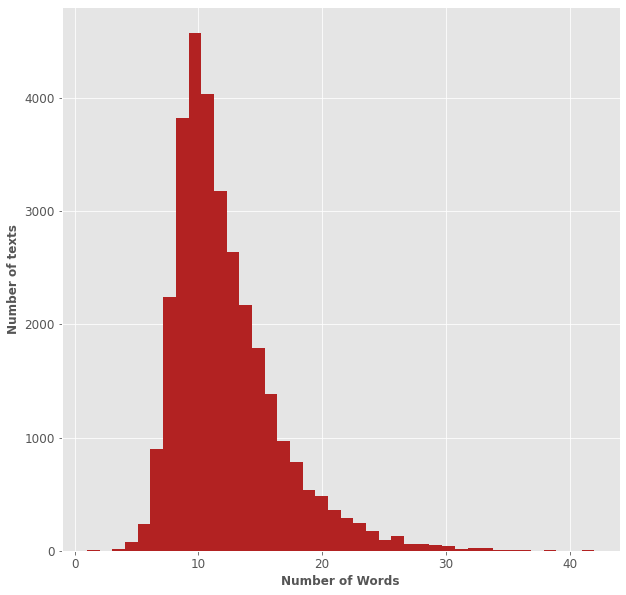

In [12]:
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 40,color='firebrick')
plt.xlabel('Number of Words')
plt.ylabel('Number of texts')

### Almost all texts have about 15 words. So, let's truncate all the texts to 15 for computational reasons

In [13]:
# tokenize and encode sequences in the train set
MAX_LENGHT = 15
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)

### Tensors
Tensors are multi-dimensional arrays with a uniform type (called a dtype). All tensors are immutable like Python numbers and straings: you can never update the contents of a tensor, you can only create one. 

Tensors have shapes as well: 
1. **Shape**: The length of each of the axes of a tensor
2. **Rank**: Number of tensor axes. A scalar has rank 0, a vecotr has rank 1, a matrix has rank 2
3. **Dimension**: A dimension of a tensor
4. **Size**: The total number of items in the tensor, the product of the shape vector's elements

We use tensors to encode the inputs and outputs of a model, as well as the model's parameters. The key difference between tensors and NumPy arrays is that tensors have accelerator support like GPU and TPU and are immutable. 

In [14]:
## convert lists to tensors

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

### Data Loader structure definition

**TensorDataset** is a ready to use class to represent your data as a list of tensors.

**DataLoader** combines a dataset and a sampler, and provides an iterable over the given dataset. It is a class for pytorch data loading utility. There are two types of datasets; map-style and iterable-syle datasets. 

In [15]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

### Freeze the parameters and define the trainable BERT structure

BERT is a language representation model that has supringly performed well in diverse language underand benchmarks. This result indicates the possibility that BERT networkds capture stuctural information about language. Back in 2018, Google developed a powerful transformer-based machine learning model for NLP applications that outperforms pervious language models in different benchmark datasets. This model is called BERT - which stands for **B**idrirectional **E**ncoder **R**epresentations from **T**ransformers.

There are two different BERT models:
1. Base: consists of 12 layers of tranformer encoder, 12 attention heads, 768 hidden size, and 110M parameters
2. Large: consists of 24 layers of transformer encoder, 16 attention heads, 1024 hidden size, and 340 parameters

It is pre-trained on unlabeled data extracted from BooksCorpus, which has 800M words, and from Wikipedia, which has 2.5T words. It's bilateral nature means that is learns information from a sequence of words not only from left to right, but also from right to left. 

In [16]:
for param in bert.parameters():
    param.requires_grad = False
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      cls_hs = self.bert(sent_id, attention_mask=mask)['pooler_output']
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x

In [17]:
model = BERT_Arch(bert)

### Define the hyperparameters (optimizer, weights of the classes and the epochs)

In [22]:
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(),
                  lr = 1e-5)          # learning rate
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
#class_weights = compute_class_weight('balanced', np.unique(train_labels), train_labels)

class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(train_labels),
                                        y = train_labels                                                    
                                    )

print("Class Weights:",class_weights)
weights= torch.tensor(class_weights,dtype=torch.float)

# define the loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 10

Class Weights: [1.04815902 0.95607204]


### Define training and evaluation functions

In [28]:
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r for r in batch]
    sent_id, mask, labels = batch
    #print(type(labels),type(mask),type(sent_id))
    #print(sent_id)
    # clear previously calculated gradients 
    model.zero_grad()        
    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [29]:
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      #elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

### Train and predict

In [30]:
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10
  Batch    50  of    983.
  Batch   100  of    983.
  Batch   150  of    983.
  Batch   200  of    983.
  Batch   250  of    983.
  Batch   300  of    983.
  Batch   350  of    983.
  Batch   400  of    983.
  Batch   450  of    983.
  Batch   500  of    983.
  Batch   550  of    983.
  Batch   600  of    983.
  Batch   650  of    983.
  Batch   700  of    983.
  Batch   750  of    983.
  Batch   800  of    983.
  Batch   850  of    983.
  Batch   900  of    983.
  Batch   950  of    983.

Evaluating...
  Batch    50  of    211.
  Batch   100  of    211.
  Batch   150  of    211.
  Batch   200  of    211.

Training Loss: 0.467
Validation Loss: 0.404

 Epoch 2 / 10
  Batch    50  of    983.
  Batch   100  of    983.
  Batch   150  of    983.
  Batch   200  of    983.
  Batch   250  of    983.
  Batch   300  of    983.
  Batch   350  of    983.
  Batch   400  of    983.
  Batch   450  of    983.
  Batch   500  of    983.
  Batch   550  of    983.
  Batch   600  of    983.


In [31]:

#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [32]:
with torch.no_grad():
  preds = model(test_seq, test_mask)
  preds = preds.detach().cpu().numpy()

### Let's check performance

In [33]:
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.86      0.92      0.89      3212
           1       0.92      0.86      0.89      3523

    accuracy                           0.89      6735
   macro avg       0.89      0.89      0.89      6735
weighted avg       0.89      0.89      0.89      6735



### Display the classification matrix

In [40]:
import sklearn
sklearn.metrics.confusion_matrix(preds,test_y)

array([[2945,  493],
       [ 267, 3030]], dtype=int64)

## Universal Sentence Encoder + PyCaret

### Embed the model

In [41]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

### Encode the dataset

In [43]:
data_matrix = embed(data.title.tolist())

### Do the train-test split

In [44]:
train_data = data.loc[0:int(len(data)*0.8)]
test_data = data.loc[int(len(data)*0.8):len(data)]

### Do the PCA with 3 components

The first principle componenet is computed so that is explains the greatest amount of variance. 
The second principle component is orthogonal to the first, it explains the greatst amount of variance left after the first component. 

The original data can be represented as feature vectors. PCA allows us to go a step further and represent the data as linear combinations of principal components. 

Formally, PCA is a statistical technique for reducing the dimensionality of a dataset. This is accomplished by performing a linear transformation of the data into a new coordinate system where the variation in the data can be described with fewer dimensions than the initial data. PCA finds lines, planes in the k-dimensional space that approximate the data as well as possible in the least squares sense.

PCA creates a visualization of data that minimizaes the residual variance in the leas-squares sense and maximiaes the variance of the projection coordinates.

In [45]:
pca = PCA(n_components=3)
pca_data = pca.fit(data_matrix[0:len(train_data)])
pca_train = pca.transform(data_matrix[0:len(train_data)])

In [57]:
pca_3_data = pd.DataFrame({'First Component':pca_train[:,0],'Second Component':pca_train[:,1],'Third Component':pca_train[:,2],'Target': train_data.Target})

### Look at the PCA dataset

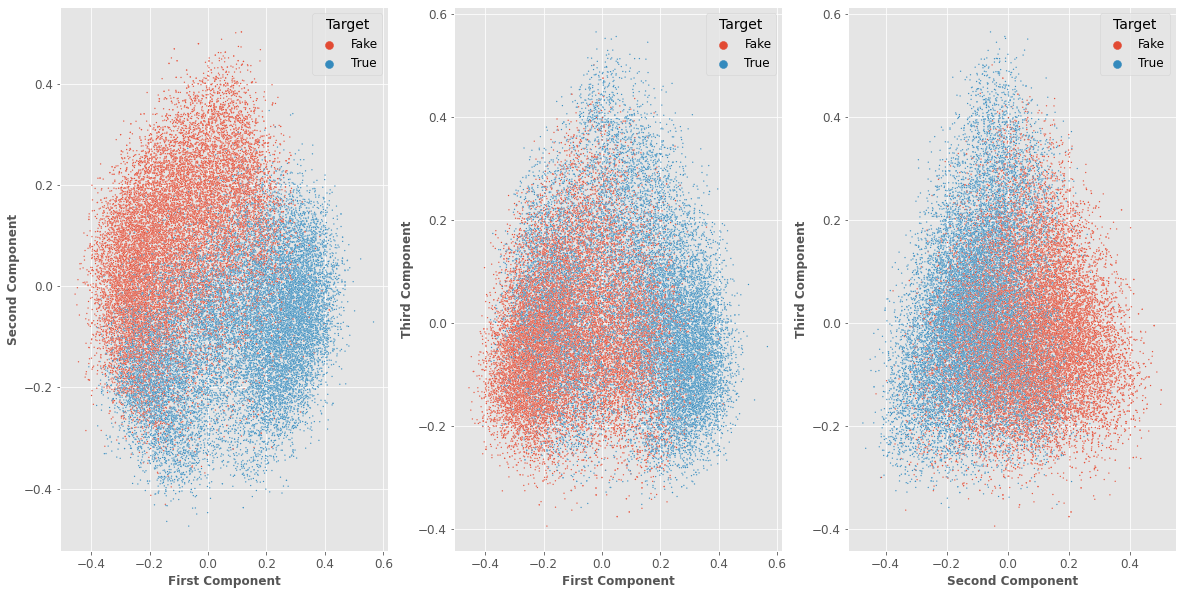

In [58]:
pca_3_data = pd.DataFrame({'First Component':pca_train[:,0],'Second Component':pca_train[:,1],'Third Component':pca_train[:,2],'Target': train_data.Target})
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
sns.scatterplot(x='First Component', y = 'Second Component',hue='Target',data=pca_3_data,s=2)
plt.grid(True)
plt.subplot(1,3,2)
sns.scatterplot(x='First Component', y = 'Third Component',hue='Target',data=pca_3_data,s=2)
plt.grid(True)
plt.subplot(1,3,3)
sns.scatterplot(x='Second Component', y = 'Third Component',hue='Target',data=pca_3_data,s=2)
plt.grid(True)

### Use PyCaret and its ML models

In [68]:
setup(data = pca_3_data, target='Target', fold_shuffle=True, session_id=2, imputation_type='iterative')

,Description,Value
0,session_id,2
1,Target,Target
2,Target Type,Binary
3,Label Encoded,"Fake: 0, True: 1"
4,Original Data,"(35919, 4)"
5,Missing Values,False
6,Numeric Features,3
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


INFO:logs:create_model_container: 0
INFO:logs:master_model_container: 0
INFO:logs:display_container: 0


AttributeError: 'Make_Time_Features' object has no attribute 'list_of_features'

In [69]:
le = LabelEncoder()
y_true = le.fit_transform(test_data.Target)

In [70]:
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8781,0.9473,0.8620,0.8813,0.8715,0.7556,0.7558,0.3170
et,Extra Trees Classifier,0.8771,0.9517,0.8661,0.8762,0.8711,0.7536,0.7537,0.2240
catboost,CatBoost Classifier,0.8697,0.9447,0.8666,0.8625,0.8645,0.7390,0.7391,3.3960
xgboost,Extreme Gradient Boosting,0.8686,0.9433,0.8638,0.8625,0.8631,0.7368,0.7369,0.3110
lightgbm,Light Gradient Boosting Machine,0.8683,0.9441,0.8647,0.8613,0.8629,0.7361,0.7363,0.1470
gbc,Gradient Boosting Classifier,0.8672,0.9435,0.8717,0.8545,0.8629,0.7342,0.7344,0.3090
ada,Ada Boost Classifier,0.8602,0.9384,0.8515,0.8562,0.8538,0.7198,0.7199,0.0970
qda,Quadratic Discriminant Analysis,0.8590,0.9365,0.8680,0.8429,0.8552,0.7180,0.7183,0.0100
lda,Linear Discriminant Analysis,0.8585,0.9371,0.8668,0.8427,0.8545,0.7168,0.7172,0.0090
lr,Logistic Regression,0.8584,0.9372,0.8568,0.8494,0.8530,0.7164,0.7166,0.5510


INFO:logs:create_model_container: 15
INFO:logs:master_model_container: 15
INFO:logs:display_container: 1
INFO:logs:RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=-1, oob_score=False,
                       random_state=2, verbose=0, warm_start=False)
INFO:logs:compare_models() succesfully completed......................................


In [72]:
pca_test = pca.transform(data_matrix[len(train_data)-1:len(train_data)+len(test_data)])


In [73]:
y_pred = best_model.predict(pca_test)


In [74]:
print(classification_report(y_pred,y_true))

              precision    recall  f1-score   support

           0       0.90      0.88      0.89      4861
           1       0.86      0.89      0.88      4119

    accuracy                           0.88      8980
   macro avg       0.88      0.88      0.88      8980
weighted avg       0.88      0.88      0.88      8980



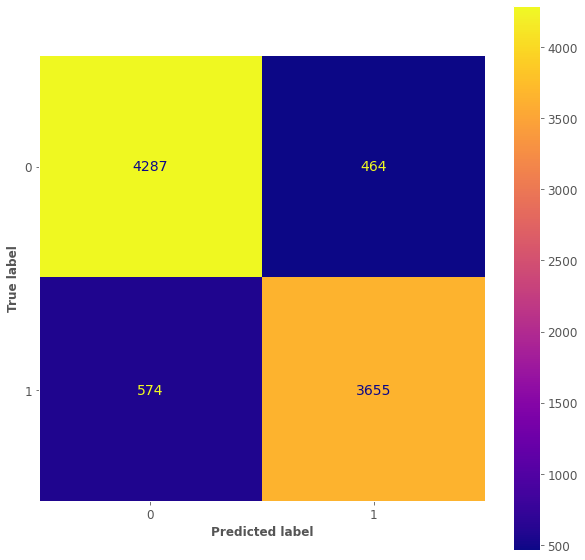

In [75]:
plot_confusion_matrix(best_model,pca_test,y_true,cmap='plasma')
